# Adding Spatial Features using Kernel
Unlike in the notebook *Constructing_features* where only 3 nearest stations were chosen, we can consider all stations and give them preferential treatment based on their distance from the station in consideration. This can be done by using a Gaussian Kernel.

## Gaussian Kernel 
This kernel is used to assign spatial weights based on distance of all other stations with respect to a particular station. These weights works as a signal of importance of other stations for the station in consideration. Higher weight (greater importance) is assigned to stations with shorter distances because of its spatial proximity and ability to predict fututre rentals for the station in consideration. <br><br>
The formula for the Gaussian function:<br>
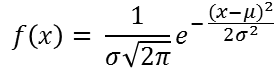
<br> 
- ***x-mu:** projected distance between other stations (Point geometries) and the station in consideration (Point geometry)*
- ***sigma:** controls the width of the Gaussian window, lower value corresponds to narrower window around mean (mu); faster weight decay* 

[*Reference*](https://mccormickml.com/2013/08/15/the-gaussian-kernel/)

In [67]:
# Defining the one-dimensional Gaussian function
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

def Gaussian1D(d, sigma):
    """Implements 1D Gaussian using the following equation 
     G(d) = \frac{1}{\sigma\sqrt{2\pi}} 
              e^{-\frac{1}{2}[\frac{(d)^2}{\sigma^2}]},
    Args:
        d (float): the shortest projected distance between two POINT geometries 
        sigma (float): standard deviation of the distribution

    Returns:
        np.array: weights evaluated on d
    """
    ATerm = 1/(sigma * np.sqrt(2 * np.pi))
    BTerm = np.exp(-0.5 * ((d)/sigma) ** 2)
    return ATerm * BTerm

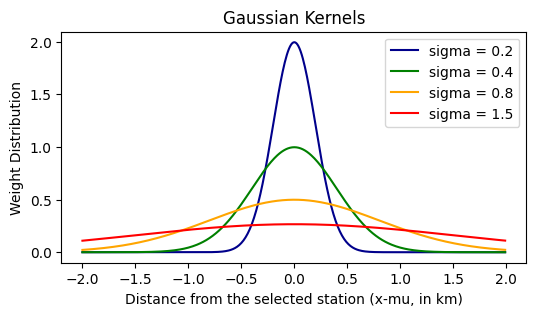

In [317]:
# Distance is specified in kilometers
d = np.arange(-2,2,0.01)

# What the kernel looks like with varying values of sigma
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
plt.plot(d,Gaussian1D(d, 0.2), color = "darkblue", label = "sigma = 0.2")
plt.plot(d,Gaussian1D(d, 0.4), color = "green", label = "sigma = 0.4")
plt.plot(d,Gaussian1D(d, 0.8), color = "orange", label = "sigma = 0.8")
plt.plot(d,Gaussian1D(d, 1.5), color = "red", label = "sigma = 1.5")
plt.title("Gaussian Kernels")
plt.xlabel("Distance from the selected station (x-mu, in km)")
plt.ylabel("Weight Distribution")
plt.legend()
plt.show()

In [123]:
# How distance calculation is being done
dist = Point(-73.9383,40.7923272).distance([Point(-73.9383,40.7923272), Point(-73.9349,40.8006721)])
dist

array([0.        , 0.00901096])

In [126]:
# Weight Assignment using the Gaussian function, sigma = 2
print(Gaussian1D(dist, 2))

# Weight Assignment using the Gaussian function, sigma = 1
dist = Point(-73.9383,40.7923272).distance([Point(-73.9383,40.7923272), Point(-73.9349,40.8006721)])
print(Gaussian1D(dist, 1))

[0.19947114 0.19946912]
[0.39894228 0.39892608]


## Defining a Weight Matrix
After defining the Gaussian kernel, this kernel is used to generate a weight matrix. The generated weights are going to be sensitive to the value of parameter **sigma**. Since in the dataset there are a 200 stations that are present both in close and far-away proximity, a narrower Gaussian window would be preferred. The **sigma** value is chosen in such a way that stations lying within *500m vicinity* are assigned some weights while for stations that are outside *1km vicinity* no considerable weights are assigned. This is the distance window for dense urban cities such as New York City (see references).
<br><br>
[Reference 1](https://www.c40knowledgehub.org/s/article/Walkable-station-spacing-is-key-to-successful-equitable-bike-share?language=en_US&utm_source=chatgpt.com)<br>
[Reference 2](https://nacto.org/wp-content/uploads/NACTO_Walkable-Station-Spacing-Is-Key-For-Bike-Share_Sc.pdf)<br>
[Reference 3](https://news.cornell.edu/stories/2020/01/if-it-takes-hike-riders-wont-go-bike-sharing?utm_source=chatgpt.com)

In [15]:
# Importing the dataset (sorting order: month, ID, day, hour)
import pandas as pd
selected_rentals = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 5 (TU Dresden)\Research Task - Spatial Modelling\Code\rentals_solving_the_problem_with_lag_var.csv")
selected_rentals.head()

,#_rentals,datetime,year,month,day,hour,ID,coordinates,#_rentals_lag_1,name_of_day,weekend,is_holiday,#_rentals_lag_2,prev_day,prev_week,roll_avg
0,0,2024-01-01 08:00:00,2024,1,1,8,0,POINT (-73.9383 40.7923272),NaN,Monday,0,1,NaN,NaN,NaN,NaN
1,0,2024-01-01 10:00:00,2024,1,1,10,0,POINT (-73.9383 40.7923272),0.0,Monday,0,1,NaN,NaN,NaN,NaN
2,0,2024-01-01 12:00:00,2024,1,1,12,0,POINT (-73.9383 40.7923272),0.0,Monday,0,1,0.0,NaN,NaN,NaN
3,0,2024-01-01 14:00:00,2024,1,1,14,0,POINT (-73.9383 40.7923272),0.0,Monday,0,1,0.0,NaN,NaN,NaN
4,0,2024-01-01 16:00:00,2024,1,1,16,0,POINT (-73.9383 40.7923272),0.0,Monday,0,1,0.0,NaN,NaN,NaN


In [34]:
# Creating a station location table

# station list
station_dict = {'station_id' : selected_rentals.ID.unique()}
station_df = pd.DataFrame(station_dict)
station_df['coord'] = None

# adding location
for i in station_df.station_id:
    station_df.loc[station_df['station_id'] == i, 'coord'] = selected_rentals.loc[selected_rentals["ID"] == i, 'coordinates'].unique()
    
station_df.head()

,station_id,coord
0,0,POINT (-73.9383 40.7923272)
1,9,POINT (-73.94594 40.7817212)
2,54,POINT (-73.92743647098541 40.772768286288304)
3,55,POINT (-73.9225403 40.7774552)
4,62,POINT (-73.9349 40.8006721)


In [35]:
# The coordinates are stored as str, not as Point geom
station_df.iloc[0].iloc[1] # This is because it was saved in a csv format

'POINT (-73.9383 40.7923272)'

In [48]:
# Str objects must be converted into Point objects
list_conv = station_df.iloc[0].iloc[1][7:-1].split()
print(list_conv)

lng = float(list_conv[0])
lat = (list_conv[1])
print(Point(lng, lat)) # Shapely Point objects have (lng, lat) format

['-73.9383', '40.7923272']
POINT (-73.9383 40.7923272)


In [52]:
# Converting to Point objects
coord_list = []

for i in station_df.coord:
    list_conv = i[7:-1].split()
    lng = float(list_conv[0])
    lat = (list_conv[1])
    coord_list.append(Point(lng, lat))

coord_list[:5] # converted to Point geometries

[<POINT (-73.938 40.792)>,
 <POINT (-73.946 40.782)>,
 <POINT (-73.927 40.773)>,
 <POINT (-73.923 40.777)>,
 <POINT (-73.935 40.801)>]

In [54]:
# Switching str with Point objects
station_df["coord"] = coord_list
type(station_df.iloc[0].iloc[1]) # successfully updated

shapely.geometry.point.Point

In [81]:
# Creating a distance matrix
distance_matrix = pd.DataFrame(index=station_df['station_id'], columns=station_df['station_id'])    
distance_matrix.shape

(200, 200)

In [114]:
# Filling values
for id1, pt1 in zip(station_df['station_id'], station_df['coord']):
    for id2, pt2 in zip(station_df['station_id'], station_df['coord']):
        distance_matrix.loc[id1, id2] = (pt1.distance(pt2))*111   
        # Converting distance from degrees into kilometers (rough approximation)  
        
distance_matrix

station_id,0,9,54,55,62,63,66,67,72,74,...,1879,1881,1884,2010,2017,2062,2063,2064,2065,2074
station_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.450906,2.483443,2.405256,1.000216,1.253569,1.353011,1.047407,2.669642,3.180469,...,2.366186,3.170778,3.385023,3.358986,1.335789,2.079797,2.416114,2.774453,2.979182,2.875793
9,1.450906,0.0,2.281679,2.640178,2.434466,2.692832,0.283748,0.505746,3.456159,3.74635,...,3.615743,4.409294,4.658033,4.609324,1.689296,3.520876,3.860825,4.219895,4.42447,4.150312
54,2.483443,2.281679,0.0,0.752345,3.206204,3.374225,2.518112,2.504796,2.007712,1.894247,...,4.72289,5.498685,5.663942,3.773688,1.188147,3.664125,3.976166,4.285104,4.457465,3.470397
55,2.405256,2.640178,0.752345,0.0,2.919504,3.040391,2.827448,2.732117,1.257287,1.194533,...,4.425986,5.164344,5.298149,3.05086,1.097784,3.148914,3.435127,3.71715,3.875157,2.778334
62,1.000216,2.434466,3.206204,2.919504,0.0,0.25976,2.300836,1.987664,2.736022,3.371454,...,1.519121,2.294109,2.473088,2.820077,2.020945,1.215065,1.518198,1.863858,2.065631,2.335287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062,2.079797,3.520876,3.664125,3.148914,1.215065,0.988622,3.432194,3.123975,2.45697,3.147963,...,1.800706,2.297277,2.334796,1.795714,2.60163,0.0,0.345223,0.702854,0.906136,1.362818
2063,2.416114,3.860825,3.976166,3.435127,1.518198,1.275766,3.766786,3.45725,2.658593,3.345729,...,1.840396,2.222333,2.216662,1.733196,2.934158,0.345223,0.0,0.359238,0.563657,1.361299
2064,2.774453,4.219895,4.285104,3.71715,1.863858,1.61557,4.124314,3.814323,2.860611,3.537352,...,1.990536,2.248177,2.194871,1.691536,3.26917,0.702854,0.359238,0.0,0.20473,1.403586


In [66]:
# Distances are saved as float values
type(distance_matrix.loc[0,9])

float

In [148]:
# Creating a weight matrix
weight_matrix = pd.DataFrame(index=station_df['station_id'], columns=station_df['station_id'])     
for i in list(weight_matrix.index):  # Loop over rows
    for j in list(weight_matrix.columns):  # Loop over columns
        weight_matrix.loc[i,j] = Gaussian1D(distance_matrix.loc[i,j],0.4)

weight_matrix

station_id,0,9,54,55,62,63,66,67,72,74,...,1879,1881,1884,2010,2017,2062,2063,2064,2065,2074
station_id,,,,,,,,,,,,,,,,,,,,,
0,0.997356,0.001386,0.0,0.0,0.043762,0.007348,0.003269,0.032356,0.0,0.0,...,0.0,0.0,0.0,0.0,0.003778,0.000001,0.0,0.0,0.0,0.0
9,0.001386,0.997356,0.0,0.0,0.0,0.0,0.775497,0.448451,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000134,0.0,0.0,0.0,0.0,0.0
54,0.0,0.0,0.997356,0.170083,0.0,0.0,0.0,0.0,0.000003,0.000013,...,0.0,0.0,0.0,0.0,0.012104,0.0,0.0,0.0,0.0,0.0
55,0.0,0.0,0.170083,0.997356,0.0,0.0,0.0,0.0,0.007136,0.011542,...,0.0,0.0,0.0,0.0,0.023083,0.0,0.0,0.0,0.0,0.0
62,0.043762,0.0,0.0,0.0,0.997356,0.807746,0.0,0.000004,0.0,0.0,...,0.000736,0.0,0.0,0.0,0.000003,0.009889,0.000742,0.000019,0.000002,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062,0.000001,0.0,0.0,0.0,0.009889,0.047031,0.0,0.0,0.0,0.0,...,0.00004,0.0,0.0,0.000042,0.0,0.997356,0.687233,0.213011,0.076648,0.003008
2063,0.0,0.0,0.0,0.0,0.000742,0.006165,0.0,0.0,0.0,0.0,...,0.000025,0.0,0.0,0.000084,0.0,0.687233,0.997356,0.666354,0.369543,0.003047
2064,0.0,0.0,0.0,0.0,0.000019,0.000286,0.0,0.0,0.0,0.0,...,0.000004,0.0,0.0,0.00013,0.0,0.213011,0.666354,0.997356,0.874914,0.002114


In [149]:
# Min and max assigned weights
print(min(weight_matrix[0]), max(weight_matrix[0]))

2.8046385687316597e-16 0.9973557010035817


In [150]:
# Weight distribution based on distance from station_id = 0
print(weight_matrix[0].sort_values()[-16:], distance_matrix[0].sort_values(ascending=False)[-16:])

station_id
62      0.043762
908     0.043964
1610    0.051141
895     0.101662
902     0.162159
906     0.164674
1386    0.187365
891     0.216723
1609    0.293931
905     0.294158
114      0.36639
904     0.430868
115     0.443513
894     0.651869
901     0.699878
0       0.997356
Name: 0, dtype: object station_id
62      1.000216
908     0.999479
1610    0.974969
895     0.854812
902     0.762424
906     0.759187
1386    0.731475
891     0.698911
1609    0.625271
905     0.625074
114     0.566084
904     0.518245
115     0.509236
894     0.368896
901     0.336666
0            0.0
Name: 0, dtype: object


For *sigma = 0.4*, stations that lie outside the **1 km vicinity** don't carry considerable weights. Most higher weights are distributed by the kernel for stations that lie within the *500m vicinity*.

## Genearting Spatiotemporal Features
The features that will now be generated will make use of a *weighted average* approach. The features are exactly defined in the section below

### Using rentals from other stations: lagged by *t-1*
For a given station, all the other station's rentals are considered (lagged by a time unit). A weighted avg is then calculated based on the weights defined in the weight matrix (derived using the Gaussian Kernel). 
<br><br>
**Note:** Station's own lagged rentals are not calculated here!

In [189]:
# for a station with a given ID, say '0'
h = weight_matrix.loc[0,:]
h[h.index != 54]

station_id
0       0.997356
9       0.001386
55           0.0
62      0.043762
63      0.007348
          ...   
2062    0.000001
2063         0.0
2064         0.0
2065         0.0
2074         0.0
Name: 0, Length: 199, dtype: object

In [212]:
# Defining a function to calculate the weighted average
def weighted_avg_func(station_id, month, day, hour):
    
    multiplicative_term = [] # empty list
    
    weights = weight_matrix.loc[station_id,:]
    weights = weights[weights.index != station_id] # only station in proximity are retained
    
    for i in list(weights.index):
        multiplicative_term.append(weights[i]*selected_rentals.loc[(selected_rentals.month == month) & (selected_rentals.ID == i) & (selected_rentals.day == day) & (selected_rentals.hour == hour), "#_rentals_lag_1"].iloc[0])
    return np.nansum(multiplicative_term)/np.sum(weights)

In [226]:
# Calculating weighted average for station 0 (on March 13th at 16:00)
weighted_avg_func(0, 3, 13, 16)

2.1780730999962126

In [247]:
# Verifying the calculated average manually

reduced_df = selected_rentals[(selected_rentals.month == 3)&(selected_rentals.day == 13)&(selected_rentals.hour == 16)&(selected_rentals.ID != 0)]
index = list(weight_matrix.loc[0].iloc[1:].index)
itr = []
for i in index:
    itr.append(weight_matrix.loc[0,i]*reduced_df.loc[reduced_df.ID == i, "#_rentals_lag_1"].iloc[0])
np.nansum(itr)/np.sum(weight_matrix.loc[0].iloc[1:])  # The calculation is correct

2.1780730999962126

In [250]:
# Empty List
weight_avg_jan_list = []

In [270]:
# Adding lagged rental values from stations in proximity (January only)
for j in selected_rentals.ID.unique():
    for k in selected_rentals[(selected_rentals.month == 1) & (selected_rentals.ID == j)].day.unique():
        for l in selected_rentals[(selected_rentals.month == 1) & (selected_rentals.ID == j) & (selected_rentals.day == k)].hour.unique():
                weight_avg_jan_list.append(weighted_avg_func(j,1,k,l))

In [271]:
print(len(selected_rentals[selected_rentals.month==1]),len(weight_avg_jan_list))

43400 43400


In [278]:
# Exporting the list with lagged_rentals (t-1) for Jan:

# file is saved as a text document (.txt)
with open('lagged_rentals_weighted_avg_jan_list.txt', 'w') as f:
    for item in weight_avg_jan_list:
        f.write(f"{item}\n") 

In [275]:
# Empty List
weight_avg_feb_list = []

# Adding lagged rental values from stations in proximity (Feb only)
for j in selected_rentals.ID.unique():
    for k in selected_rentals[(selected_rentals.month == 2) & (selected_rentals.ID == j)].day.unique():
        for l in selected_rentals[(selected_rentals.month == 2) & (selected_rentals.ID == j) & (selected_rentals.day == k)].hour.unique():
                weight_avg_feb_list.append(weighted_avg_func(j,2,k,l))

In [277]:
print(len(selected_rentals[selected_rentals.month==2]),len(weight_avg_feb_list))

40600 40600


In [279]:
# Exporting the list with lagged_rentals (t-1) for Feb:

# file is saved as a text document (.txt)
with open('lagged_rentals_weighted_avg_feb_list.txt', 'w') as f:
    for item in weight_avg_feb_list:
        f.write(f"{item}\n") 

In [281]:
# Empty List
weight_avg_mar_list = []

# Adding lagged rental values from stations in proximity (Mar only)
for j in selected_rentals.ID.unique():
    for k in selected_rentals[(selected_rentals.month == 3) & (selected_rentals.ID == j)].day.unique():
        for l in selected_rentals[(selected_rentals.month == 3) & (selected_rentals.ID == j) & (selected_rentals.day == k)].hour.unique():
                weight_avg_mar_list.append(weighted_avg_func(j,3,k,l))

In [282]:
# Exporting the list with lagged_rentals (t-1) for Mar:

# file is saved as a text document (.txt)
with open('lagged_rentals_weighted_avg_mar_list.txt', 'w') as f:
    for item in weight_avg_mar_list:
        f.write(f"{item}\n") 

In [284]:
# Empty List
weight_avg_apr_list = []

# Adding lagged rental values from stations in proximity (Apr only)
for j in selected_rentals.ID.unique():
    for k in selected_rentals[(selected_rentals.month == 4) & (selected_rentals.ID == j)].day.unique():
        for l in selected_rentals[(selected_rentals.month == 4) & (selected_rentals.ID == j) & (selected_rentals.day == k)].hour.unique():
                weight_avg_apr_list.append(weighted_avg_func(j,4,k,l))

In [286]:
# Exporting the list with lagged_rentals (t-1) for Apr:

# file is saved as a text document (.txt)
with open('lagged_rentals_weighted_avg_apr_list.txt', 'w') as f:
    for item in weight_avg_apr_list:
        f.write(f"{item}\n") 

#### Combining List
The above four lists are combined into a single dataframe column for the *selected_rentals* dataframe. 

In [287]:
# Generating a new column
selected_rentals["w_avg_lag_1"] = weight_avg_jan_list + weight_avg_feb_list + weight_avg_mar_list + weight_avg_apr_list
selected_rentals.head()

,#_rentals,datetime,year,month,day,hour,ID,coordinates,#_rentals_lag_1,name_of_day,weekend,is_holiday,#_rentals_lag_2,prev_day,prev_week,roll_avg,w_avg_lag_1
0,0,2024-01-01 08:00:00,2024,1,1,8,0,POINT (-73.9383 40.7923272),NaN,Monday,0,1,NaN,NaN,NaN,NaN,0.000000
1,0,2024-01-01 10:00:00,2024,1,1,10,0,POINT (-73.9383 40.7923272),0.0,Monday,0,1,NaN,NaN,NaN,NaN,0.378298
2,0,2024-01-01 12:00:00,2024,1,1,12,0,POINT (-73.9383 40.7923272),0.0,Monday,0,1,0.0,NaN,NaN,NaN,0.655962
3,0,2024-01-01 14:00:00,2024,1,1,14,0,POINT (-73.9383 40.7923272),0.0,Monday,0,1,0.0,NaN,NaN,NaN,0.661161
4,0,2024-01-01 16:00:00,2024,1,1,16,0,POINT (-73.9383 40.7923272),0.0,Monday,0,1,0.0,NaN,NaN,NaN,0.724537


#### Testing Prediction Performance 
The performance from this feature is compared with baseline performance that was evaluated in the *Solving The Problem With Lag Variable* notebook previously.

In [288]:
# Firstly, the conversion of ID col into dummies is required!

# creating dummies for ID
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "w_avg_lag_1"]], columns = ["ID"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data for Feb

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

2.507952946428571 0.3153811738842708


Performance increase is clearly visible, compared to baseline performance for February.

In [289]:
# Developing a training/test data for Mar

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

3.512615619047619 0.5019659350583404


Performance for March is even better, compared to the baseline.

### Using rentals from other stations: rentals from previous day
Up till now, we take the rental values of nearby stations lagged by *t-1* units. Now we take the rental values of nearby stations for same hour but lagged by a day i.e. *prev_day* variable. Again a *weighted_avg* is being calculated.

In [290]:
# Defining a function to calculate the weighted average
def weighted_avg_func_prev_day(station_id, month, day, hour):
    
    multiplicative_term = [] # empty list
    
    weights = weight_matrix.loc[station_id,:]
    weights = weights[weights.index != station_id] # only station in proximity are retained
    
    for i in list(weights.index):
        multiplicative_term.append(weights[i]*selected_rentals.loc[(selected_rentals.month == month) & (selected_rentals.ID == i) & (selected_rentals.day == day) & (selected_rentals.hour == hour), "prev_day"].iloc[0])
    return np.nansum(multiplicative_term)/np.sum(weights)

In [292]:
# Empty List
weight_avg_list_prev_day = []

# Adding prev_day rental values from stations in proximity 
for i in selected_rentals.month.unique():
    for j in selected_rentals.ID.unique():
        for k in selected_rentals[(selected_rentals.month == i) & (selected_rentals.ID == j)].day.unique():
            for l in selected_rentals[(selected_rentals.month == i) & (selected_rentals.ID == j) & (selected_rentals.day == k)].hour.unique():
                weight_avg_list_prev_day.append(weighted_avg_func_prev_day(j,i,k,l))

In [294]:
# Exporting the list:

# file is saved as a text document (.txt)
with open('lagged_rentals_weighted_avg_prev_day_list.txt', 'w') as f:
    for item in weight_avg_list_prev_day:
        f.write(f"{item}\n") 

In [295]:
# Introducing this list as a column
selected_rentals["w_avg_prev_day"] = weight_avg_list_prev_day
selected_rentals.columns

Index(['#_rentals', 'datetime', 'year', 'month', 'day', 'hour', 'ID',
       'coordinates', '#_rentals_lag_1', 'name_of_day', 'weekend',
       'is_holiday', '#_rentals_lag_2', 'prev_day', 'prev_week', 'roll_avg',
       'w_avg_lag_1', 'w_avg_prev_day'],
      dtype='object')

#### Testing it with baseline performance
The performance from this feature is compared with baseline performance that was evaluated in the *Solving The Problem With Lag Variable* notebook previously.

In [296]:
# Firstly, the conversion of ID col into dummies is required!

# creating dummies for ID
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "w_avg_prev_day"]], columns = ["ID"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data for Feb

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

# Developing a training/test data for Mar

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

2.3477862321428575 0.35910334501720587
3.8143476547619053 0.45918504225155743


There is performance increase here as well, particularly for the February data.

### Using rentals from other stations: rentals from rolling average
Now we take the 7 day rolling average of rental values of nearby stations. For these calculation the *roll_avg* column will be used. Again, a *weighted_avg* of these values is being calculated.

In [297]:
# Defining a function to calculate the weighted average
def weighted_avg_func_roll_avg(station_id, month, day, hour):
    
    multiplicative_term = [] # empty list
    
    weights = weight_matrix.loc[station_id,:]
    weights = weights[weights.index != station_id] # only station in proximity are retained
    
    for i in list(weights.index):
        multiplicative_term.append(weights[i]*selected_rentals.loc[(selected_rentals.month == month) & (selected_rentals.ID == i) & (selected_rentals.day == day) & (selected_rentals.hour == hour), "roll_avg"].iloc[0])
    return np.nansum(multiplicative_term)/np.sum(weights)

In [298]:
# Empty List
weight_avg_list_roll_avg = []

# Adding roll_avg rental values from stations in proximity 
for i in selected_rentals.month.unique():
    for j in selected_rentals.ID.unique():
        for k in selected_rentals[(selected_rentals.month == i) & (selected_rentals.ID == j)].day.unique():
            for l in selected_rentals[(selected_rentals.month == i) & (selected_rentals.ID == j) & (selected_rentals.day == k)].hour.unique():
                weight_avg_list_roll_avg.append(weighted_avg_func_roll_avg(j,i,k,l))

In [299]:
# Exporting the list:

# file is saved as a text document (.txt)
with open('lagged_rentals_weighted_avg_roll_avg_list.txt', 'w') as f:
    for item in weight_avg_list_roll_avg:
        f.write(f"{item}\n") 

In [300]:
# Introducing this list as a column
selected_rentals["w_avg_roll_avg"] = weight_avg_list_roll_avg
selected_rentals.columns

Index(['#_rentals', 'datetime', 'year', 'month', 'day', 'hour', 'ID',
       'coordinates', '#_rentals_lag_1', 'name_of_day', 'weekend',
       'is_holiday', '#_rentals_lag_2', 'prev_day', 'prev_week', 'roll_avg',
       'w_avg_lag_1', 'w_avg_prev_day', 'w_avg_roll_avg'],
      dtype='object')

#### Testing it with baseline performance
The performance from this feature is compared with baseline performance that was evaluated in the *Solving The Problem With Lag Variable* notebook previously.

In [301]:
# Firstly, the conversion of ID col into dummies is required!

# creating dummies for ID
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "w_avg_roll_avg"]], columns = ["ID"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data for Feb

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

# Developing a training/test data for Mar

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

2.405064946428571 0.34346745113349253
3.8245035476190483 0.4577450951718578


Performance has improved for both months, particularly for the February data.

### Using rentals from other stations: lagged by *t-2*
For a given station, all the other station's rentals are considered (lagged by two time units). A weighted avg is then calculated based on the weights defined in the weight matrix (derived using the Gaussian Kernel). 
<br><br>
**Note:** Station's own lagged rentals (lagged by two time units) are not calculated here!

In [302]:
# Defining a function to calculate the weighted average
def weighted_avg_func_lag_2(station_id, month, day, hour):
    
    multiplicative_term = [] # empty list
    
    weights = weight_matrix.loc[station_id,:]
    weights = weights[weights.index != station_id] # only station in proximity are retained
    
    for i in list(weights.index):
        multiplicative_term.append(weights[i]*selected_rentals.loc[(selected_rentals.month == month) & (selected_rentals.ID == i) & (selected_rentals.day == day) & (selected_rentals.hour == hour), "#_rentals_lag_2"].iloc[0])
    return np.nansum(multiplicative_term)/np.sum(weights)

In [303]:
# Empty List
weight_avg_list_lag_2 = []

# Adding lagged 't-2' rental values from stations in proximity 
for i in selected_rentals.month.unique():
    for j in selected_rentals.ID.unique():
        for k in selected_rentals[(selected_rentals.month == i) & (selected_rentals.ID == j)].day.unique():
            for l in selected_rentals[(selected_rentals.month == i) & (selected_rentals.ID == j) & (selected_rentals.day == k)].hour.unique():
                weight_avg_list_lag_2_2.append(weighted_avg_func_lag_2(j,i,k,l))

In [304]:
# Exporting the list:

# file is saved as a text document (.txt)
with open('lagged_rentals_weighted_avg_lag_2_list.txt', 'w') as f:
    for item in weight_avg_list_lag_2:
        f.write(f"{item}\n") 

In [305]:
# Introducing this list as a column
selected_rentals["w_avg_lag_2"] = weight_avg_list_lag_2
selected_rentals.columns

Index(['#_rentals', 'datetime', 'year', 'month', 'day', 'hour', 'ID',
       'coordinates', '#_rentals_lag_1', 'name_of_day', 'weekend',
       'is_holiday', '#_rentals_lag_2', 'prev_day', 'prev_week', 'roll_avg',
       'w_avg_lag_1', 'w_avg_prev_day', 'w_avg_roll_avg', 'w_avg_lag_2'],
      dtype='object')

#### Testing it with baseline performance
The performance from this feature is compared with baseline performance that was evaluated in the *Solving The Problem With Lag Variable* notebook previously.

In [306]:
# Firstly, the conversion of ID col into dummies is required!

# creating dummies for ID
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "w_avg_lag_2"]], columns = ["ID"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data for Feb

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

# Developing a training/test data for Mar

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

2.5909740714285716 0.2927181389891198
3.7000739285714284 0.47538727288051075


Performance has increased for both months, particularly for the month of March.

In [309]:
# Exporting the entire dataframe with all generated features
selected_rentals.to_csv('rentals_working_with_gaussian_kernel.csv', index=False)

## Overall Performance - Default Hyperparameters
Here, all temporal and spatiotemporal features that were created have been used altogether. This shows how the overall performance might look like without tuning for *random forest*.

### Is_holiday is not considered
It was previously seen that this variable may not contribute to the performance significantly. So, the performance is first evaluated without this variable.

In [310]:
selected_rentals.columns

Index(['#_rentals', 'datetime', 'year', 'month', 'day', 'hour', 'ID',
       'coordinates', '#_rentals_lag_1', 'name_of_day', 'weekend',
       'is_holiday', '#_rentals_lag_2', 'prev_day', 'prev_week', 'roll_avg',
       'w_avg_lag_1', 'w_avg_prev_day', 'w_avg_roll_avg', 'w_avg_lag_2'],
      dtype='object')

In [311]:
# is_holiday is omitted

# creating dummies for ID and name_of_day
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "name_of_day", "weekend", "#_rentals_lag_2", "prev_day", "prev_week", "roll_avg", "w_avg_lag_1", "w_avg_prev_day", "w_avg_roll_avg", "w_avg_lag_2"]], columns = ["ID","name_of_day"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data for Feb

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

# Developing a training/test data for Mar

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

1.9072388571428571 0.4793635864026622
3.4469188452380957 0.5112807120969909


### Considering the is_holiday variable

In [312]:
# is_holiday is omitted

# creating dummies for ID and name_of_day
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "name_of_day", "weekend", "#_rentals_lag_2", "prev_day", "prev_week", "roll_avg", "w_avg_lag_1", "w_avg_prev_day", "is_holiday", "w_avg_roll_avg", "w_avg_lag_2"]], columns = ["ID","name_of_day"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data for Feb

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

# Developing a training/test data for Mar

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

1.9037748392857143 0.48030919100117664
3.464954226190476 0.5087235765995063


There is no contribution of using *is_holiday* in predicting rentals.

### MSE if only mean was predicted

In [314]:
# MSE if only mean was predicted: Feb data (test)
calculated_mean_Feb = np.mean(selected_rentals.loc[(selected_rentals["day"] > 25) & (selected_rentals["month"] == 2), "#_rentals"])
print(mean_squared_error([calculated_mean_Feb]*len(selected_rentals.loc[(selected_rentals["day"] > 25) & (selected_rentals["month"] == 2), "#_rentals"]), selected_rentals.loc[(selected_rentals["day"] > 25) & (selected_rentals["month"] == 2), "#_rentals"]))

3.663283641581633


In [315]:
# MSE if only mean was predicted: Mar data (test)
calculated_mean_Mar = np.mean(selected_rentals.loc[(selected_rentals["day"] > 25) & (selected_rentals["month"] == 3), "#_rentals"])
print(mean_squared_error([calculated_mean_Mar]*len(selected_rentals.loc[(selected_rentals["day"] > 25) & (selected_rentals["month"] == 3), "#_rentals"]), selected_rentals.loc[(selected_rentals["day"] > 25) & (selected_rentals["month"] == 3), "#_rentals"]))

7.052962570861678


## Does Changing Training Data Impact Performance?
- Training on a two month dataset (January and February) leads to an r2 score ~0.45; here test data was first two weeks of March.
- Training entirely on the month of February and testing for the first two weeks of March; r2 score ~0.41

In [319]:
# is_holiday is omitted

# creating dummies for ID and name_of_day
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "name_of_day", "weekend", "#_rentals_lag_2", "prev_day", "prev_week", "roll_avg", "w_avg_lag_1", "w_avg_prev_day", "is_holiday", "w_avg_roll_avg", "w_avg_lag_2"]], columns = ["ID","name_of_day"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data

# training data: entire month of Feb
X_train = selected_rentals_dum.loc[(selected_rentals_dum["month"] ==2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["month"] ==2), "#_rentals"]

# test data: first two weeks of March
X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] < 15) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] < 15) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

3.3833632755102037 0.4172351313501912


## Adding Weather Information
Python's *Meteostat* library is used. **Note** that in this library the generally used convention for the *Point* geometry is **(lat, lng)**.

In [398]:
# !pip install meteostat
from meteostat import Point as MeteostatPoint
from shapely.geometry import Point as ShapelyPoint
from meteostat import Hourly
from datetime import datetime

location = MeteostatPoint(40.7923272, -73.9383)
start = datetime(2024, 1, 1, 8)
end = datetime(2024, 1, 1, 20)

# Access weather data
data = Hourly(location, start, end)
data = data.fetch()

# Accessing data for 7 time periods - by Day
data_df = pd.DataFrame(data)[["temp","rhum", "prcp", "wspd"]].iloc[[0,2,4,6,8,10,12]].reset_index()
data_df["Shapely_coords"] = ShapelyPoint(location._lon, location._lat)
data_df
# these columns aren't useful: snow, wdir, tsun, dwpt, wpgt, pres

,time,temp,rhum,prcp,wspd,Shapely_coords
0,2024-01-01 08:00:00,5.0,62.0,0.0,6.0,POINT (-73.9383 40.7923272)
1,2024-01-01 10:00:00,5.0,65.0,0.0,7.0,POINT (-73.9383 40.7923272)
2,2024-01-01 12:00:00,4.0,82.0,0.0,6.0,POINT (-73.9383 40.7923272)
3,2024-01-01 14:00:00,5.0,73.0,0.0,6.0,POINT (-73.9383 40.7923272)
4,2024-01-01 16:00:00,7.0,60.0,0.0,6.0,POINT (-73.9383 40.7923272)
5,2024-01-01 18:00:00,7.0,56.0,0.0,6.8,POINT (-73.9383 40.7923272)
6,2024-01-01 20:00:00,8.0,53.0,0.0,6.0,POINT (-73.9383 40.7923272)


Possibly useful weather variables:
- temp (in Celcius)
- rhum (relative humidity)
- prcp (precipitation)
- wspd (wind speed)

In [432]:
from shapely.geometry import Point
from meteostat import Point as MeteostatPoint

# Converting to Point objects
meteostat_coord_list = []

for i in selected_rentals["coordinates"].unique():
    list_conv = i[7:-1].split()
    lng = float(list_conv[0])
    lat = (list_conv[1])
    meteostat_coord_list.append(Point(lat, lng))

meteostat_coord_list[:5] # converted to Point geometries

[<POINT (40.792 -73.938)>,
 <POINT (40.782 -73.946)>,
 <POINT (40.773 -73.927)>,
 <POINT (40.777 -73.923)>,
 <POINT (40.801 -73.935)>]

In [442]:
# Creating a dataframe that stores weather information for all 200 locations
from meteostat import Point as MeteostatPoint
from shapely.geometry import Point as ShapelyPoint
from meteostat import Hourly
from datetime import datetime

weather_data = pd.DataFrame()
weather_data[["temp","rhum", "prcp", "wspd"]] = None
start = datetime(2024, 1, 1, 8)
end = datetime(2024, 4, 30, 20)


for i in meteostat_coord_list:
    location_coord = MeteostatPoint(i.x, i.y)
    data = Hourly(location_coord, start, end)
    data = data.fetch()
    data_df = pd.DataFrame(data)[["temp","rhum", "prcp", "wspd"]].reset_index()
    data_df["Shapely_coords"] = ShapelyPoint(i.y, i.x)
    weather_data = pd.concat([weather_data, data_df], ignore_index=True)

len(weather_data["Shapely_coords"].unique())

200

In [447]:
# In rentals dataset, the timestamp is saved as a string
selected_rentals.datetime[0]

'2024-01-01 08:00:00'

In [466]:
# And coordinates are saved as a string object
selected_rentals.loc[0, "coordinates"]

'POINT (-73.9383 40.7923272)'

In [448]:
# Converting to timestamp
selected_rentals["datetime"] = [pd.to_datetime(x) for x in selected_rentals.datetime]
selected_rentals.datetime[0]

Timestamp('2024-01-01 08:00:00')

In [485]:
# Converting Point geometries into str: weather_data
weather_data["Shapely_coords"] = [str(x) for x in weather_data.Shapely_coords]
weather_data.Shapely_coords[0]

'POINT (-73.9383 40.7923272)'

In [491]:
# Introducing empty columns
selected_rentals[["temp", "rhum", "prcp", "wspd"]] = None

for i in range(len(selected_rentals)):
    dt = selected_rentals.datetime[i]
    str_geom = selected_rentals.coordinates[i]  
    selected_rentals.loc[i,["temp", "rhum", "prcp", "wspd"]] = weather_data.loc[(weather_data.time == dt) & (weather_data.Shapely_coords == str_geom), ["temp", "rhum", "prcp", "wspd"]].iloc[0]

In [493]:
# Updating the dataframe with all generated features
selected_rentals.to_csv('rentals_working_with_gaussian_kernel.csv', index=False)

### Comparing prediction performance with the baseline

In [494]:
# Firstly, the conversion of ID col into dummies is required!

# creating dummies for ID
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "temp", "rhum", "prcp", "wspd"]], columns = ["ID"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data for Feb

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

# Developing a training/test data for Mar

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

2.2688519285714284 0.38065076293359434
3.5511385119047616 0.4965039901706284


The weather data is immensely valuable. The prediction performance for both months has drastically increased!

## Checking the Overall Performance Again

In [495]:
# is_holiday is omitted

# creating dummies for ID and name_of_day
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "name_of_day", "weekend", "#_rentals_lag_2", "prev_day", "prev_week", "roll_avg", "w_avg_lag_1", "w_avg_prev_day", "w_avg_roll_avg", "w_avg_lag_2", "temp","rhum", "prcp", "wspd"]], columns = ["ID","name_of_day"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data for Feb

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

# Developing a training/test data for Mar

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

1.8804979285714285 0.48666330195509566
3.357292119047619 0.5239883828509457


In [496]:
# is_holiday is considered

# creating dummies for ID and name_of_day
selected_rentals_dum = pd.get_dummies(selected_rentals[["#_rentals", "is_holiday", "year", "month", "day", "hour", "ID", "#_rentals_lag_1", "name_of_day", "weekend", "#_rentals_lag_2", "prev_day", "prev_week", "roll_avg", "w_avg_lag_1", "w_avg_prev_day", "w_avg_roll_avg", "w_avg_lag_2", "temp","rhum", "prcp", "wspd"]], columns = ["ID","name_of_day"], drop_first=False)
selected_rentals_dum.head()

# Developing a training/test data for Feb

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 2), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

# Developing a training/test data for Mar

# training data
X_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_train = selected_rentals_dum.loc[(selected_rentals_dum["day"] <=25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

X_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3),list(selected_rentals_dum.columns)[1:]]
y_test = selected_rentals_dum.loc[(selected_rentals_dum["day"] >25) & (selected_rentals_dum["month"] == 3), "#_rentals"]

# training the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=2) 
forest.fit(X_train, y_train)

# testing performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_test_pred = forest.predict(X_test)
print(mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred))

1.8768888392857142 0.48764850802670523
3.3584201071428574 0.5238284517462637


is_holiday isn't influencing prediction performance in any way!